#### Install & Import Required Libraries

In [0]:
# Databricks Notebook for Lung Disease Classification with MLflow
# 1️⃣ Install required libraries
%pip install tensorflow mlflow matplotlib

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xfff53fd20360>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import mlflow
import mlflow.tensorflow

In [0]:
%pip install kaggle


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


#### Extracting Data from Kaggle API

In [0]:
import json
import os

# Create a local folder for Kaggle config
kaggle_dir = "/tmp/kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

# Save your kaggle.json there
kaggle_json = {
    "username": "khizraghaffar",
    "key": "<YPUR_API_KEY>"
}

with open(f"{kaggle_dir}/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)


In [0]:
os.environ['KAGGLE_CONFIG_DIR'] = kaggle_dir


In [0]:
!kaggle datasets list


I0000 00:00:1760466785.725839    4483 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000           8970        188  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           3808         89  0.8235294        
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           2755        103  1.0              
jaderz/hospital

In [0]:

# 3️⃣ Create a folder for the dataset
dataset_path = "/tmp/lung_data"
os.makedirs(dataset_path, exist_ok=True)

# 4️⃣ Download and unzip the Kaggle dataset
!kaggle datasets download -d fatemehmehrparvar/lung-disease -p {dataset_path} --unzip

I0000 00:00:1760466786.668594    4483 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)
  0%|                                               | 0.00/34.9M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.9M/34.9M [00:00<00:00, 1.58GB/s]


In [0]:
import os

DATASET_PATH = "/tmp/lung_data"

for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files[:5]:  # only show first 5 files per folder
        print(f"{indent}    {f}")


lung_data/
    Lung X-Ray Image/
        Lung X-Ray Image/
            Normal/
                664.jpg
                377.jpg
                212.jpg
                687.jpg
                23.jpg
            Lung_Opacity/
                664.jpg
                377.jpg
                212.jpg
                687.jpg
                23.jpg
            Viral Pneumonia/
                664.jpg
                377.jpg
                212.jpg
                687.jpg
                23.jpg


In [0]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [0]:
DATASET_PATH = "/tmp/lung_data/Lung X-Ray Image/Lung X-Ray Image"  # <- folder that contains NORMAL, PNEUMONIA, COVID

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("Classes:", class_names)


Found 3475 files belonging to 3 classes.
Classes: ['Lung_Opacity', 'Normal', 'Viral Pneumonia']


#### Display few Images from Batch#1

2025-10-14 18:33:13.104671: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


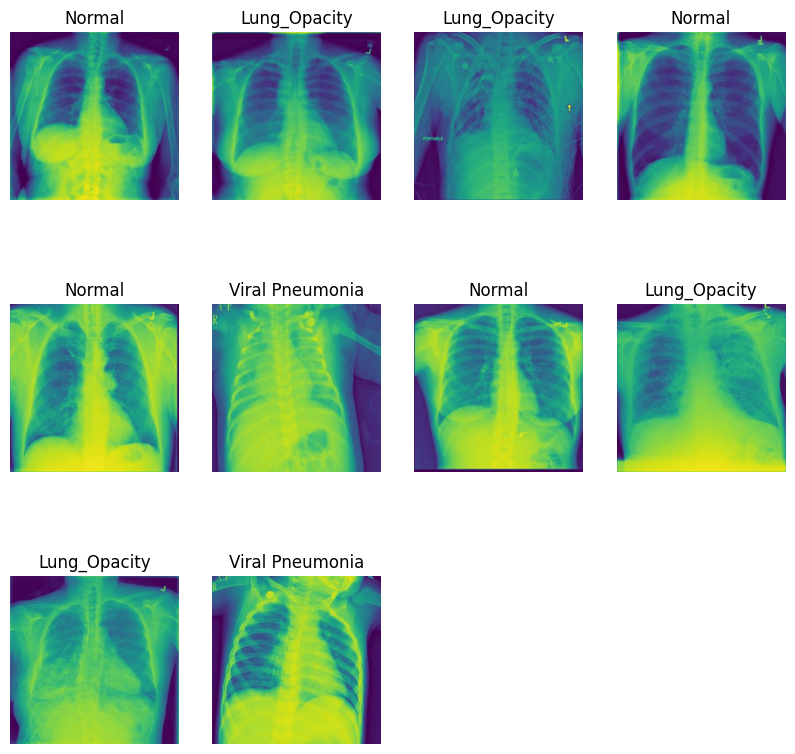

In [0]:
# Visualize some samples
plt.figure(figsize=(10,10))
for images, labels in dataset.take(1):
    for i in range(10):
        plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# 5️⃣ Split dataset
def preparing_Dataset(original_dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_length = len(original_dataset)
    if shuffle:
        ds = original_dataset.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * dataset_length)
    val_size = int(val_split * dataset_length)
    
    training_dataset = original_dataset.take(train_size)
    validation_dataset = original_dataset.skip(train_size).take(val_size)
    testing_dataset = original_dataset.skip(train_size).skip(val_size)
    
    return training_dataset, validation_dataset, testing_dataset

training_dataset, validation_dataset, testing_dataset = preparing_Dataset(dataset)

#### Data Preprocessing & Transformation

In [0]:
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset = testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# 6️⃣ Preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

#### Model Training & Validation

In [0]:

# 7️⃣ Model definition
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
number_of_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax'),
])

model.summary()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-3f6929a4-9f59-4129-ac79-719999fa4b24/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [0]:

# 8️⃣ Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### MLflow Tracking with Databricks

In [0]:

# 9️⃣ MLflow tracking
mlflow.set_experiment("/Users/khizraghaffar3216@gmail.com/LungDiseaseClassification")

with mlflow.start_run(run_name="LungDisease_CNN"):
    mlflow.tensorflow.autolog()  # Automatically log metrics, params, model
    
    # 10️⃣ Train model
    history = model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=EPOCHS,
        verbose=1
    )

2025/10/08 12:07:59 INFO mlflow.tracking.fluent: Experiment with name '/Users/khizraghaffar3216@gmail.com/LungDiseaseClassification' does not exist. Creating a new experiment.
2025/10/08 12:08:00 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_2' has no defined input shape yet.
2025-10-08 12:08:06.222237: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10


2025-10-08 12:08:14.457288: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 264257536 exceeds 10% of free system memory.
2025-10-08 12:08:14.947129: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 66064384 exceeds 10% of free system memory.
2025-10-08 12:08:15.048837: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 128000000 exceeds 10% of free system memory.
2025-10-08 12:08:16.291079: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 62980096 exceeds 10% of free system memory.
2025-10-08 12:08:16.291127: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 128000000 exceeds 10% of free system memory.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6142 - loss: 0.8217

87/87 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7267 - loss: 0.6389 - val_accuracy: 0.8062 - val_loss: 0.4914
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8220 - loss: 0.4486

87/87 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8351 - loss: 0.4382 - val_accuracy: 0.8281 - val_loss: 0.3990
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8678 - loss: 0.3684

87/87 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.8592 - loss: 0.3824 - val_accuracy: 0.8531 - val_loss: 0.3803
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8631 - loss: 0.3611

87/87 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8664 - loss: 0.3493 - val_accuracy: 0.8594 - val_loss: 0.3503
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8696 - loss: 0.3269 - val_accuracy: 0.8406 - val_loss: 0.4252
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8718 - loss: 0.3217 - val_accuracy: 0.8594 - val_loss: 0.3568
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9078 - loss: 0.2623

87/87 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9045 - loss: 0.2544 - val_accuracy: 0.8500 - val_loss: 0.3132
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9086 - loss: 0.2376

87/87 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.9059 - loss: 0.2388 - val_accuracy: 0.8906 - val_loss: 0.2864
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9127 - loss: 0.2181 - val_accuracy: 0.8656 - val_loss: 0.3195
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9177 - loss: 0.2046 - val_accuracy: 0.8906 - val_loss: 0.3047


2025-10-08 12:37:42.927644: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


2025/10/08 12:37:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


#### Model Performance with Test Dataset

In [0]:

# 11️⃣ Evaluate model
test_loss, test_accuracy = model.evaluate(testing_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_loss", test_loss)

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 596ms/step - accuracy: 0.8760 - loss: 0.4058
Test Accuracy: 0.8760, Test Loss: 0.4058


In [0]:

# 12️⃣ Plot metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

#### Training & Validation Visualization

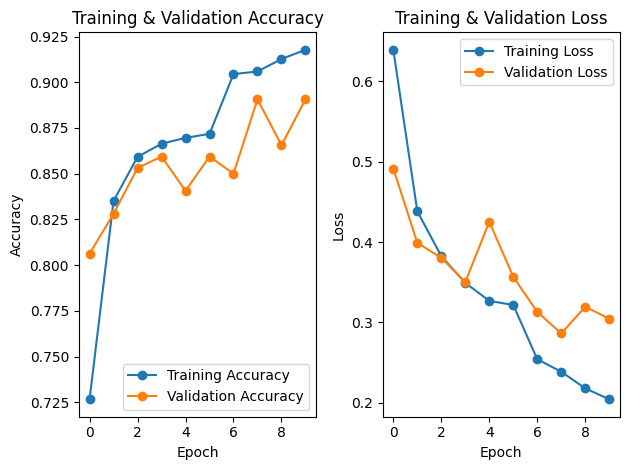

2025/10/08 12:42:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-6b041a36-5183.cloud.databricks.com/ml/experiments/1707758485364563/models/m-01f6e64669a14ee5a009595904ed1403?o=1962372897807296
2025/10/08 12:42:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/10/08 12:42:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [0]:

# Accuracy
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), train_loss, label='Training Loss', marker='o')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# 13️⃣ Save model to MLflow
mlflow.tensorflow.log_model(model, "model")


#### Predicting Image#1 with Batch#1

Prediction for First Image
Actual Class Label: Viral Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model Predicted Class Label (first image): Viral Pneumonia


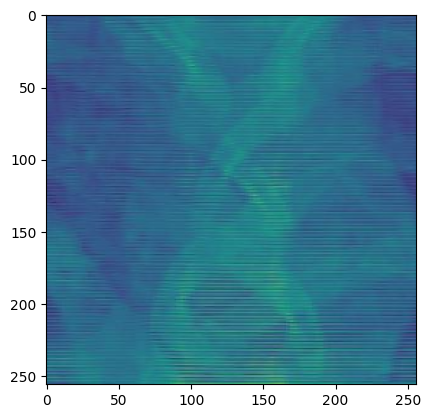

In [0]:
import numpy as np
for images_in_batch, labels_for_images in testing_dataset.take(1):
    
    first_image = images_in_batch[0].numpy().astype('uint8')
    first_label = labels_for_images[0].numpy()
    
    print("Prediction for First Image")
    plt.imshow(first_image)
    print("Actual Class Label:",class_names[first_label])
    
    prediction_for_all_batch_images = model.predict(images_in_batch)
    print("Model Predicted Class Label (first image):",class_names[np.argmax(prediction_for_all_batch_images[0])])

In [0]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Predicting few Images from Batch#1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


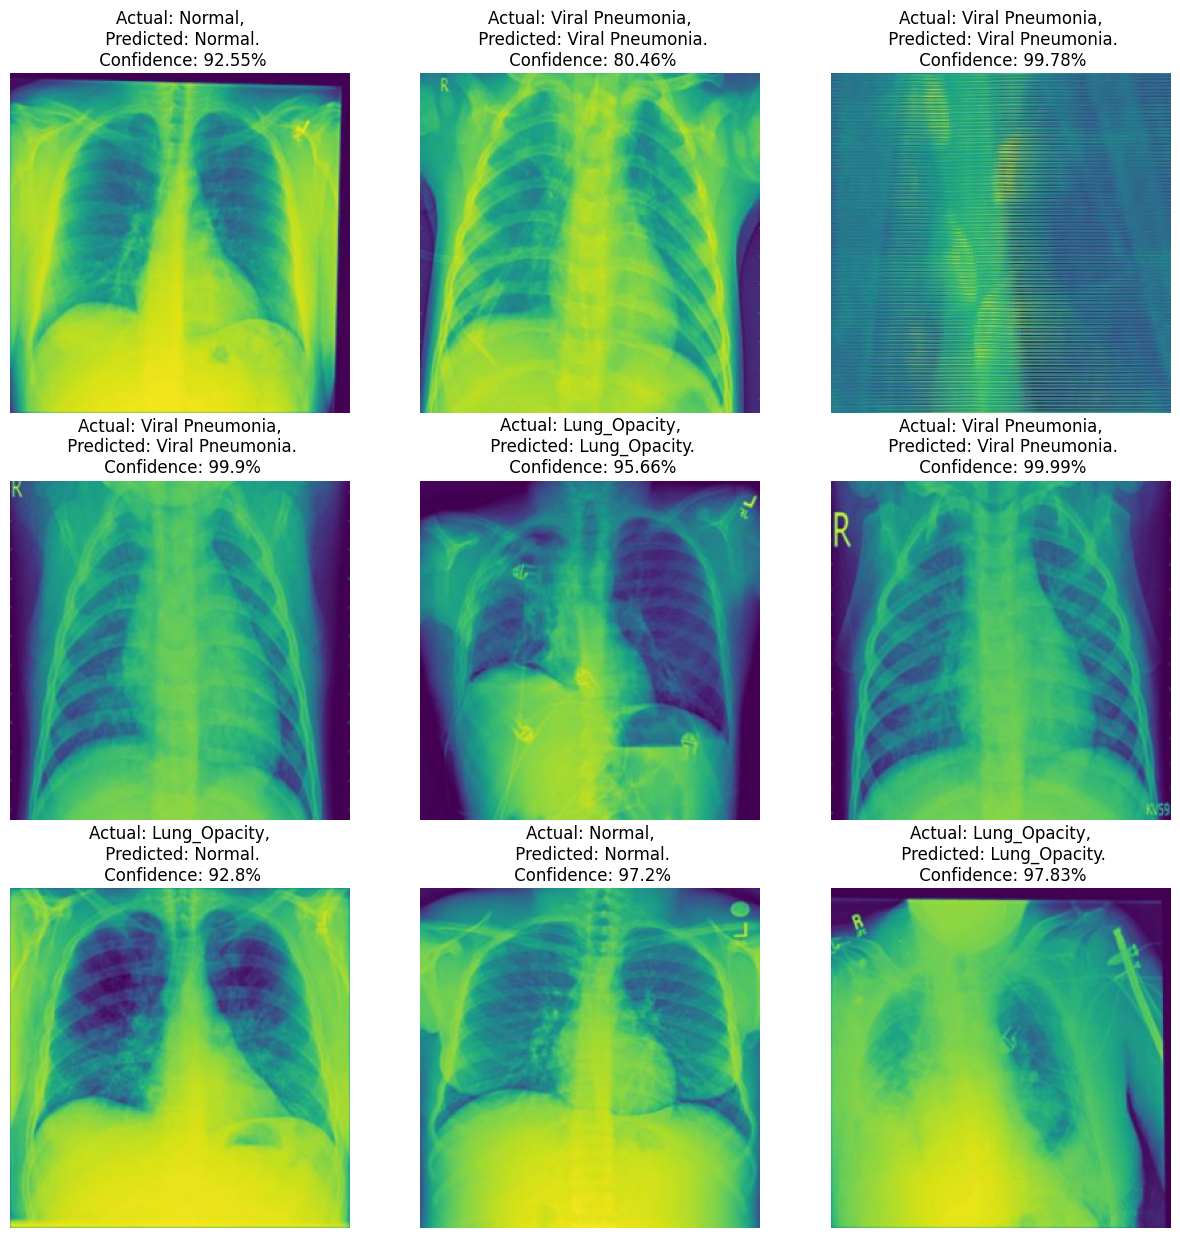

In [0]:
plt.figure(figsize=(15, 15))
for images, labels in testing_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")



### Hyperparameter Optimization using Hyperopt

In [0]:
%pip install hyperopt

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:465)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:743)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:299)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import mlflow
import mlflow.tensorflow

# Define search space for hyperparameters
search_space = {
    'conv_filters': hp.choice('conv_filters', [32, 64, 128]),
    'dense_units': hp.choice('dense_units', [64, 128, 256]),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 1e-2),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

mlflow.tensorflow.autolog()
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
number_of_classes = len(class_names)

def objective(params):
    tf.keras.backend.clear_session()
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        
        # Build model with given parameters
        model = tf.keras.Sequential([
            tf.keras.Input(shape=input_shape),
            resize_and_rescale,
            layers.Conv2D(params['conv_filters'], (3,3), activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Conv2D(params['conv_filters'], (3,3), activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Flatten(),
            layers.Dense(params['dense_units'], activation='relu'),
            layers.Dense(number_of_classes, activation='softmax')
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        history = model.fit(
            training_dataset,
            validation_data=validation_dataset,
            epochs=5,
            verbose=0
        )
        
        val_acc = history.history['val_accuracy'][-1]
        mlflow.log_metric('val_accuracy', val_acc)
        
        # Return metric to minimize (negative accuracy)
        return {'loss': -val_acc, 'status': STATUS_OK}


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:465)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:743)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:299)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
mlflow.set_experiment("/Users/khizraghaffar3216@gmail.com/LungDisease1_Hyperopt")
trials = Trials()

best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,  # number of trials
    trials=trials
)

print("Best parameters found:", best_params)


  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2025/10/09 07:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Parameter with key batch_size was already logged with a value of 32. The attempted new value was None



 20%|██        | 1/5 [1:10:34<4:42:16, 4234.19s/trial, best loss: -0.3375000059604645]

2025/10/09 08:09:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Parameter with key batch_size was already logged with a value of 64. The attempted new value was None



 40%|████      | 2/5 [1:39:39<2:18:30, 2770.10s/trial, best loss: -0.3375000059604645]

2025/10/09 08:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Parameter with key batch_size was already logged with a value of 64. The attempted new value was None



 60%|██████    | 3/5 [2:06:57<1:15:06, 2253.30s/trial, best loss: -0.8218749761581421]

2025/10/09 09:01:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Parameter with key batch_size was already logged with a value of 16. The attempted new value was None



 80%|████████  | 4/5 [2:31:54<32:34, 1954.67s/trial, best loss: -0.8218749761581421]  

2025/10/09 09:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Parameter with key batch_size was already logged with a value of 16. The attempted new value was None



100%|██████████| 5/5 [3:04:57<00:00, 2219.52s/trial, best loss: -0.8843749761581421]
Best parameters found: {'batch_size': 0, 'conv_filters': 1, 'dense_units': 2, 'learning_rate': 0.0007751617844442384}


In [0]:
print("Best parameters found:", best_params)


Best parameters found: {'batch_size': 0, 'conv_filters': 1, 'dense_units': 2, 'learning_rate': 0.0007751617844442384}


#### Extract Optimal Hyperparameters

In [0]:
conv_filters_options = [32, 64, 128]
dense_units_options = [64, 128, 256]
batch_size_options = [16, 32, 64]

# Safely map indices to values
conv_index = best_params.get('conv_filters')
dense_index = best_params.get('dense_units')
batch_index = best_params.get('batch_size')

if conv_index is not None and 0 <= conv_index < len(conv_filters_options):
    best_params['conv_filters'] = conv_filters_options[conv_index]
else:
    print("Warning: conv_filters index out of range")

if dense_index is not None and 0 <= dense_index < len(dense_units_options):
    best_params['dense_units'] = dense_units_options[dense_index]
else:
    print("Warning: dense_units index out of range")

if batch_index is not None and 0 <= batch_index < len(batch_size_options):
    best_params['batch_size'] = batch_size_options[batch_index]
else:
    print("Warning: batch_size index out of range")

print("Mapped Best Hyperparameters:", best_params)


Mapped Best Hyperparameters: {'batch_size': 16, 'conv_filters': 64, 'dense_units': 256, 'learning_rate': 0.0007751617844442384}


In [0]:
conv_filters = best_params['conv_filters']
dense_units = best_params['dense_units']
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']

In [0]:
conv_filters = 64
dense_units = 256
batch_size = 16
learning_rate = 0.0007751617844442384

#### Another Run for Trial and Errors

In [0]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
number_of_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(conv_filters, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(dense_units, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-eaf21642-aa8d-408f-8add-6bd0646be108/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Model Training with Optimal Hyperparameters

In [0]:

# 7️⃣ Model definition
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
number_of_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(conv_filters, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(dense_units, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax'),
])

model.summary()

In [0]:

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [0]:
import mlflow
import mlflow.tensorflow

In [0]:


# 9️⃣ MLflow tracking
mlflow.set_experiment("/Users/khizraghaffar3216@gmail.com/LungDiseaseClassificationTesting")

with mlflow.start_run(run_name="LungDisease_CNN"):
    mlflow.tensorflow.autolog()  # Automatically log metrics, params, model
    
    # 10️⃣ Train model
    history = model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=EPOCHS,
        verbose=1
    )

2025/10/11 06:27:23 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_2' has no defined input shape yet.
2025-10-11 06:27:29.140022: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10


2025-10-11 06:27:35.244121: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 251920384 exceeds 10% of free system memory.
2025-10-11 06:27:35.667221: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 251920384 exceeds 10% of free system memory.
2025-10-11 06:27:36.327255: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 251920384 exceeds 10% of free system memory.
2025-10-11 06:27:36.758700: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 251920384 exceeds 10% of free system memory.
2025-10-11 06:27:36.833229: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 251920384 exceeds 10% of free system memory.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6243 - loss: 2.4171

87/87 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.7284 - loss: 1.0324 - val_accuracy: 0.7906 - val_loss: 0.4572
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8193 - loss: 0.4266

87/87 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.8182 - loss: 0.4273 - val_accuracy: 0.8687 - val_loss: 0.3822
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8570 - loss: 0.3459

87/87 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.8520 - loss: 0.3478 - val_accuracy: 0.8719 - val_loss: 0.3464
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.8732 - loss: 0.3069 - val_accuracy: 0.8313 - val_loss: 0.3746
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8971 - loss: 0.2392

87/87 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8883 - loss: 0.2612 - val_accuracy: 0.8687 - val_loss: 0.3040
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - accuracy: 0.9059 - loss: 0.2365 - val_accuracy: 0.8438 - val_loss: 0.3303
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9129 - loss: 0.1995

87/87 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.9199 - loss: 0.1953 - val_accuracy: 0.9000 - val_loss: 0.2834
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.9450 - loss: 0.1560 - val_accuracy: 0.8844 - val_loss: 0.3126
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.9504 - loss: 0.1197 - val_accuracy: 0.8969 - val_loss: 0.3019
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.9580 - loss: 0.1099 - val_accuracy: 0.8719 - val_loss: 0.3625


2025-10-11 07:25:00.222294: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


2025/10/11 07:25:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [0]:

    # 11️⃣ Evaluate model
    test_loss, test_accuracy = model.evaluate(testing_dataset)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
    
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 870ms/step - accuracy: 0.8167 - loss: 0.5364
Test Accuracy: 0.8167, Test Loss: 0.5364


In [0]:
# 12️⃣ Plot metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

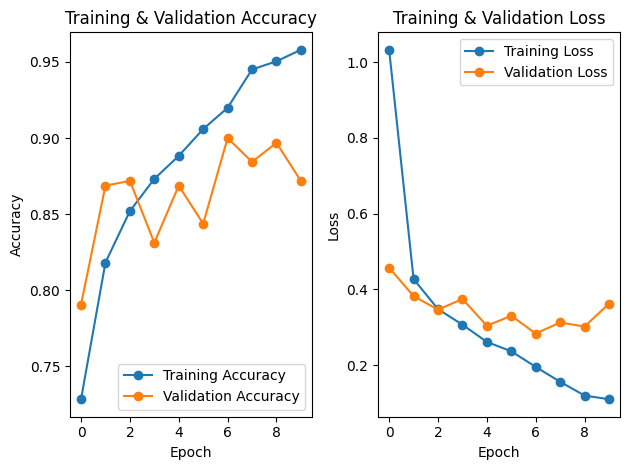

2025/10/11 07:26:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-6b041a36-5183.cloud.databricks.com/ml/experiments/1707758485364563/models/m-696ffdabdce64dbc9659c15768b34dd7?o=1962372897807296
2025/10/11 07:26:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/10/11 07:27:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [0]:

# Accuracy
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), train_loss, label='Training Loss', marker='o')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# 13️⃣ Save model to MLflow
mlflow.tensorflow.log_model(model, "model")


Prediction for First Image
Actual Class Label: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Model Predicted Class Label (first image): Normal


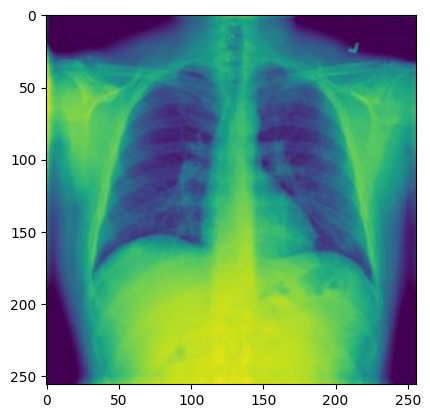

In [0]:

import numpy as np
for images_in_batch, labels_for_images in testing_dataset.take(1):
    
    first_image = images_in_batch[0].numpy().astype('uint8')
    first_label = labels_for_images[0].numpy()
    
    print("Prediction for First Image")
    plt.imshow(first_image)
    print("Actual Class Label:",class_names[first_label])
    
    prediction_for_all_batch_images = model.predict(images_in_batch)
    print("Model Predicted Class Label (first image):",class_names[np.argmax(prediction_for_all_batch_images[0])])

In [0]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


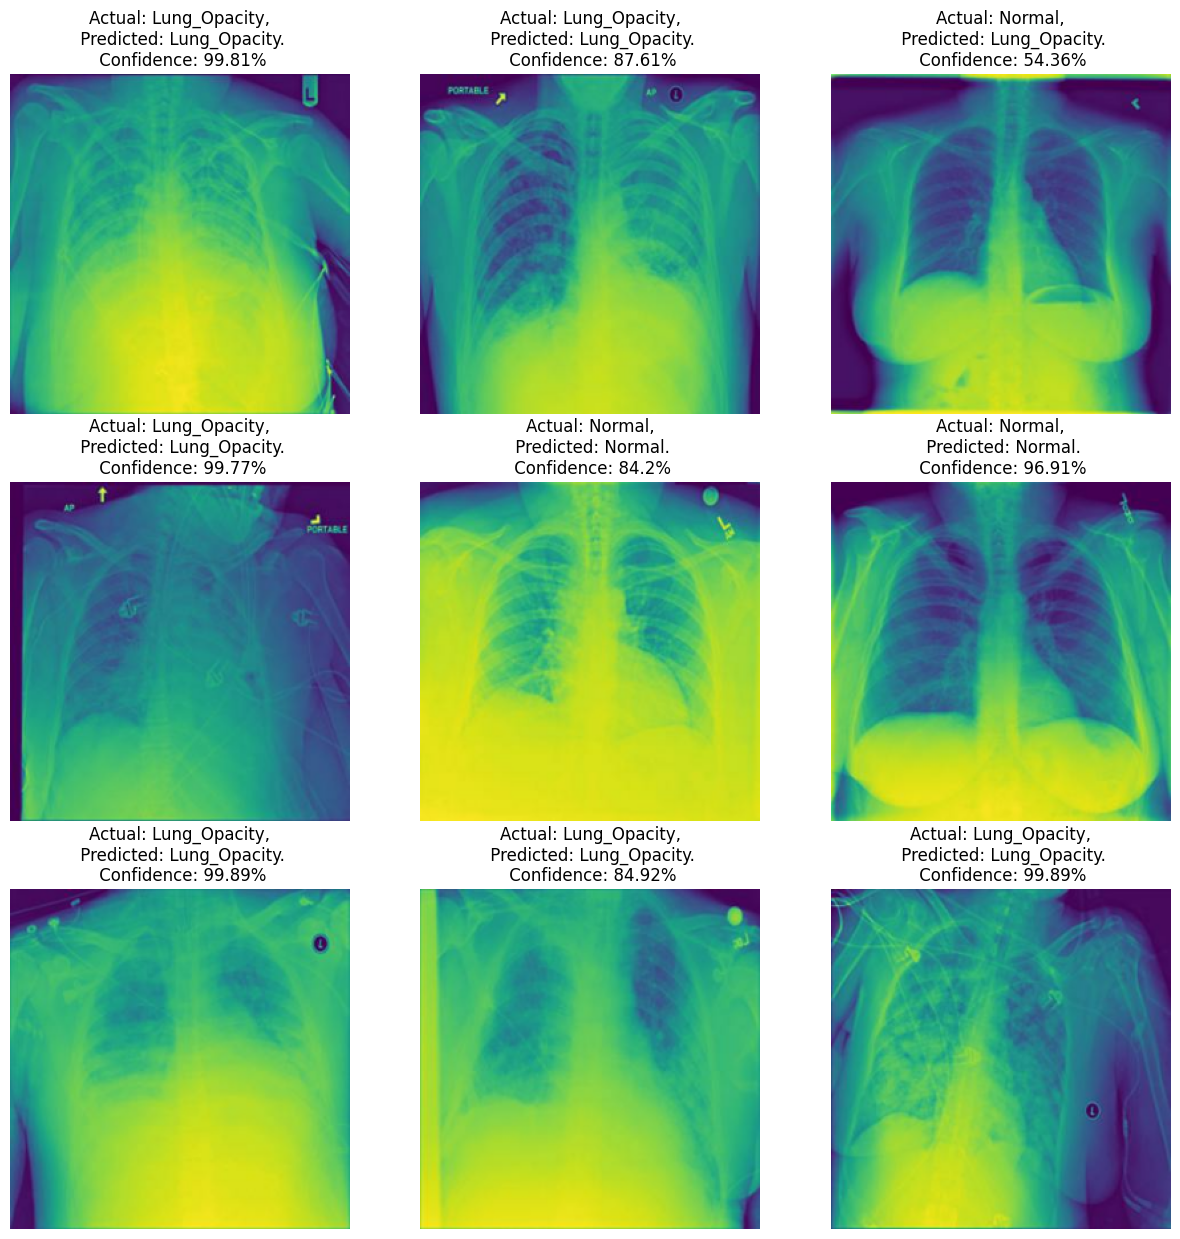

In [0]:

plt.figure(figsize=(15, 15))
for images, labels in testing_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")